In [1]:
from fastai.vision.all import *

# Convolutional kernels from scratch

In [2]:
top_edge = tensor([[-1, -1, -1],
                  [0, 0, 0],
                  [1, 1, 1]])

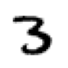

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
im3 = Image.open(path/'train/3/12.png')
show_image(im3, cmap='gray_r');

Applying a kernel means elementwise multiplication followed by summation over all elements.

In [4]:
im3_tensor = tensor(im3)
im3_tensor[0:3, 0:3] * top_edge

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [5]:
(im3_tensor[0:3, 0:3] * top_edge).sum()

tensor(0)

In [6]:
df = pd.DataFrame(im3_tensor[:10, :20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


At cell 5,7 there is a top edge to detect, so lets apply the kernel there:

In [7]:
(im3_tensor[4:7, 4:7] * top_edge).sum()

tensor(762)

... and a right edge at 8,18:

In [8]:
(im3_tensor[7:10, 17:20] * top_edge).sum()

tensor(-29)

In [9]:
def apply_kernel(t, row, col, kernel):
    return (t[row-1:row+2, col-1:col+2]*kernel).sum()

In [10]:
apply_kernel(im3_tensor, 5, 7, top_edge)

tensor(762)

Applying the kernel to each valid position:

In [11]:
rng = range(1, 27)
top_edge3 = tensor([apply_kernel(im3_tensor, row, col, top_edge) for row in rng for col in rng]).view(26, 26)

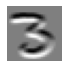

In [12]:
show_image(top_edge3, cmap='gray_r');

Convolutions from PyTorch:

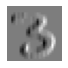

In [13]:
left_edge = tensor([[-1, 1, 0],
                   [-1, 1, 0],
                   [-1, 1, 0]])
left_edge3 = tensor([apply_kernel(im3_tensor, row, col, left_edge) for row in rng for col in rng]).view(26, 26)

show_image(left_edge3, cmap='gray_r');

In [14]:
F.conv2d

<function _VariableFunctionsClass.conv2d>

PyTorchs conv2d function can act on multiple images (batch) and apply multiple kernels at once.

In [15]:
diag1_edge = tensor([[0, -1, 1],
                    [-1, 1, 0],
                    [1, 0, 0]]).float()
diag2_edge = tensor([[1, -1, 0],
                    [0, 1, -1],
                    [0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

Testing this funcionality requires us to have a minibatch of data:

In [16]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(),
                 get_y=parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [17]:
xb = to_cpu(xb)
yb = to_cpu(yb)

The expected kernel shape is:

[features_out, channels_in, rows, columns]

The kernel tensor we have so far is missing the channels_in:

In [18]:
edge_kernels = edge_kernels.unsqueeze(1)
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [19]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

<AxesSubplot:>

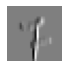

In [20]:
show_image(batch_features[0, 0, :, :], cmap='gray_r')

# Strides and padding

- Padding: Add pixel around the border to make sure that the output size after applying the convolution is the same as the input size
- Stride: Move the kernel by more than one pixel at a time

# Simple CNN

In [21]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1))

In [22]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

One way to make the shape of the output match the expected (for the prediction) is to use stride-2 convolutions to achieve the desired dimension. Note that this makes the net depend on the exact shape of the input.

In [23]:
def conv(n_input, n_filters, kernel_size=3, activation=True):
    res = nn.Conv2d(n_input, n_filters, stride=2, kernel_size=kernel_size, padding=kernel_size//2)
    if activation: res = nn.Sequential(res, nn.ReLU())
    return res

In [24]:
simple_cnn = sequential(
    conv(1, 4),
    conv(4,8),
    conv(8, 16),
    conv(16,32),
    conv(32,2, activation=False),
    Flatten())

In [25]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [26]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
___________________________________________________

In [27]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.054553,0.052877,0.982336,00:04
1,0.020399,0.031239,0.990677,00:02


# Improving training stability

In [28]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [29]:
def get_dls(bs=64):
    db = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter('training', 'testing'),
                   get_y=parent_label,
                   batch_tfms=Normalize())
    return db.dataloaders(path, bs=bs)

dls = get_dls()

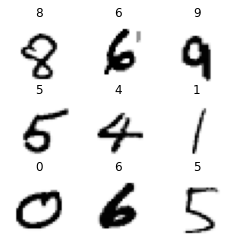

In [30]:
dls.show_batch(max_n=9, figsize=(4,4))

When increasing the amount of output filters it's important to note how many input pixels are looked at for each activation pixel. In case of a 3x3 kernel it's 9 pixels, so having 8 output filters probably won't do much. That's why we increase the kernel size to 5x5:

In [31]:
def simple_cnn():
    return sequential(
        conv(1, 8, kernel_size=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64,10, activation=False),
        Flatten())

In [32]:
from fastai.callback.hook import *

In [33]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, lr)
    return learn

In [34]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.307662,2.304240,0.101000,00:54


This didn't train at all it seems... The following plots the mean and std of the activations of the chosen layer (by index):

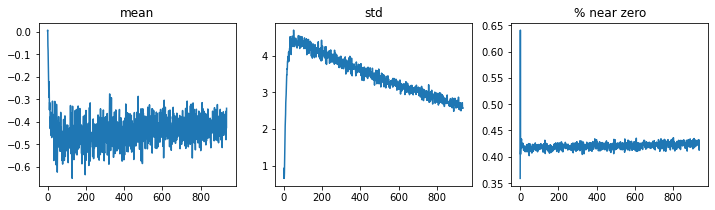

In [35]:
learn.activation_stats.plot_layer_stats(0)

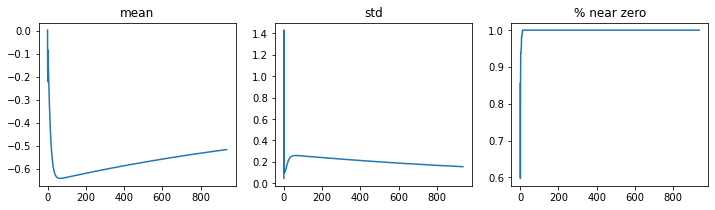

In [36]:
learn.activation_stats.plot_layer_stats(-2)

## Increase the batch size

In [37]:
dls = get_dls(512)
learn = fit(lr=6e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.476768,0.253136,0.921100,00:17


In [38]:
dls = get_dls(512)
learn = fit(lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.548369,0.247856,0.926800,00:16


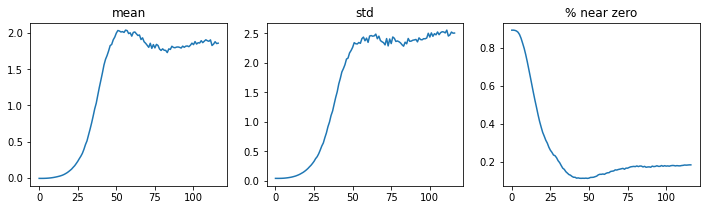

In [39]:
learn.activation_stats.plot_layer_stats(-2)

# 1cycle Training

In [40]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [41]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.218170,0.079294,0.974600,00:17


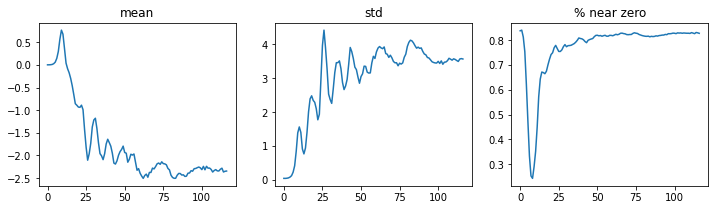

In [42]:
learn.activation_stats.plot_layer_stats(-2)

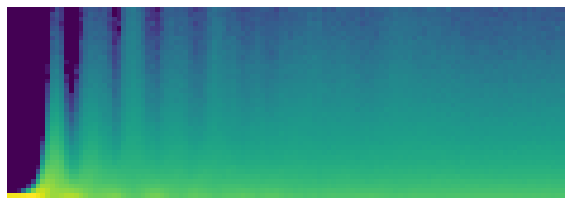

In [43]:
learn.activation_stats.color_dim(-2)

In [44]:
learn.summary()

Sequential (Input shape: ['512 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 8 x 14 x 14    208        True      
________________________________________________________________
ReLU                 512 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               512 x 16 x 7 x 7     1,168      True      
________________________________________________________________
ReLU                 512 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               512 x 32 x 4 x 4     4,640      True      
________________________________________________________________
ReLU                 512 x 32 x 4 x 4     0          False     
________________________________________________________________
Conv2d               512 x 64 x 2 x 2     18,496     True      
__________________________________________________

# BatchNorm

In [45]:
def conv(n_input, n_filters, kernel_size=3, activation=True):
    layers = [nn.Conv2d(n_input, n_filters, stride=2, kernel_size=kernel_size, padding=kernel_size//2)]
    layers.append(nn.BatchNorm2d(n_filters))
    if activation: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [46]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.138614,0.059360,0.986500,00:22


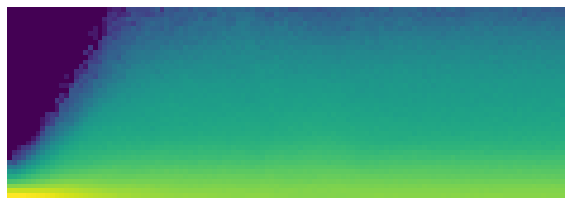

In [47]:
learn.activation_stats.color_dim(-4)

In [48]:
learn = fit(5, lr=.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.182700,0.087460,0.973000,00:22
1,0.076603,0.062632,0.980700,00:21
2,0.051598,0.050113,0.984400,00:19
3,0.031460,0.032241,0.989300,00:22
4,0.016144,0.027235,0.991200,00:22
